# Titanic: on the top with a simple model
In this kernel I intend to use nested cross validation to choose between Random Forest and SVM. 

### Steps:
* 1- Preprocessing and exploring
    * 1.1- Imports
    * 1.2- Types
    * 1.3 - Missing Values
    * 1.4 - Exploring
    * 1.5 - Feature Engineering
    * 1.6 - Prepare for models
* 2- Nested Cross Validation
* 3- Submission
    
   


## 1- Preprocessing and exploring

### 1.1 - Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import warnings


In [28]:
train=pd.read_csv("../input/titanic/train.csv")
test=pd.read_csv("../input/titanic/test.csv")
test2=pd.read_csv("../input/titanic/test.csv")
titanic=pd.concat([train, test], sort=False)
len_train=train.shape[0]

### 1.2 - Types

In [29]:
titanic.dtypes.sort_values()

PassengerId      int64
Pclass           int64
SibSp            int64
Parch            int64
Survived       float64
Age            float64
Fare           float64
Name            object
Sex             object
Ticket          object
Cabin           object
Embarked        object
dtype: object

In [30]:
titanic.select_dtypes(include='int').head()

""
0
1
2
3
4


In [31]:
titanic.select_dtypes(include='object').head()

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


In [32]:
titanic.select_dtypes(include='float').head()

,Survived,Age,Fare
0,0.0,22.0,7.2500
1,1.0,38.0,71.2833
2,1.0,26.0,7.9250
3,1.0,35.0,53.1000
4,0.0,35.0,8.0500


## 1.2 - Missing values

In [33]:
titanic.isnull().sum()[titanic.isnull().sum()>0]

Survived     418
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64

### Fare

In [35]:
train.Fare=train.Fare.fillna(train.Fare.mean())
test.Fare=test.Fare.fillna(train.Fare.mean())

### Cabin

In [36]:
train.Cabin=train.Cabin.fillna("unknow")
test.Cabin=test.Cabin.fillna("unknow")

### Embarked

In [37]:
train.Embarked=train.Embarked.fillna(train.Embarked.mode()[0])
test.Embarked=test.Embarked.fillna(train.Embarked.mode()[0])

### Age
Considering title
Inspired on: https://medium.com/i-like-big-data-and-i-cannot-lie/how-i-scored-in-the-top-9-of-kaggles-titanic-machine-learning-challenge-243b5f45c8e9

In [39]:
train['title']=train.Name.apply(lambda x: x.split('.')[0].split(',')[1].strip())
test['title']=test.Name.apply(lambda x: x.split('.')[0].split(',')[1].strip())

In [40]:
newtitles={
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"}

In [41]:
train['title']=train.title.map(newtitles)
test['title']=test.title.map(newtitles)

In [42]:
train.groupby(['title','Sex']).Age.mean()

title    Sex   
Master   male       4.574167
Miss     female    21.804054
Mr       male      32.368090
Mrs      female    35.718182
Officer  female    49.000000
         male      46.562500
Royalty  female    40.500000
         male      42.333333
Name: Age, dtype: float64

In [43]:
def newage (cols):
    title=cols[0]
    Sex=cols[1]
    Age=cols[2]
    if pd.isnull(Age):
        if title=='Master' and Sex=="male":
            return 4.57
        elif title=='Miss' and Sex=='female':
            return 21.8
        elif title=='Mr' and Sex=='male': 
            return 32.37
        elif title=='Mrs' and Sex=='female':
            return 35.72
        elif title=='Officer' and Sex=='female':
            return 49
        elif title=='Officer' and Sex=='male':
            return 46.56
        elif title=='Royalty' and Sex=='female':
            return 40.50
        else:
            return 42.33
    else:
        return Age 

In [44]:
train.Age=train[['title','Sex','Age']].apply(newage, axis=1)
test.Age=test[['title','Sex','Age']].apply(newage, axis=1)

### 1.3 - Exploring

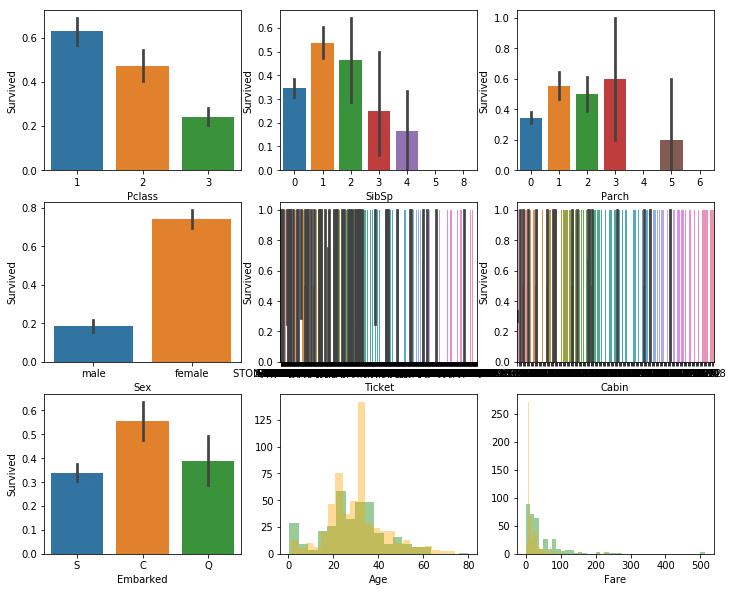

In [18]:
warnings.filterwarnings(action="ignore")
plt.figure(figsize=[12,10])
plt.subplot(3,3,1)
sns.barplot('Pclass','Survived',data=train)
plt.subplot(3,3,2)
sns.barplot('SibSp','Survived',data=train)
plt.subplot(3,3,3)
sns.barplot('Parch','Survived',data=train)
plt.subplot(3,3,4)
sns.barplot('Sex','Survived',data=train)
plt.subplot(3,3,5)
sns.barplot('Ticket','Survived',data=train)
plt.subplot(3,3,6)
sns.barplot('Cabin','Survived',data=train)
plt.subplot(3,3,7)
sns.barplot('Embarked','Survived',data=train)
plt.subplot(3,3,8)
sns.distplot(train[train.Survived==1].Age, color='green', kde=False)
sns.distplot(train[train.Survived==0].Age, color='orange', kde=False)
plt.subplot(3,3,9)
sns.distplot(train[train.Survived==1].Fare, color='green', kde=False)
sns.distplot(train[train.Survived==0].Fare, color='orange', kde=False)

SibSp and Parch don't seem to have a clear relationship with the target, so put them together can be a good idea.
For Ticket and Cabin a good strategie can be count the number of caracteres.

### 1.4 Feature Engineering

In [48]:
train['Relatives']=train.SibSp+train.Parch
test['Relatives']=test.SibSp+test.Parch

train['Ticket2']=train.Ticket.apply(lambda x : len(x))
test['Ticket2']=test.Ticket.apply(lambda x : len(x))

train['Cabin2']=train.Cabin.apply(lambda x : len(x))
test['Cabin2']=test.Cabin.apply(lambda x : len(x))

train['Name2']=train.Name.apply(lambda x: x.split(',')[0].strip())
test['Name2']=test.Name.apply(lambda x: x.split(',')[0].strip())

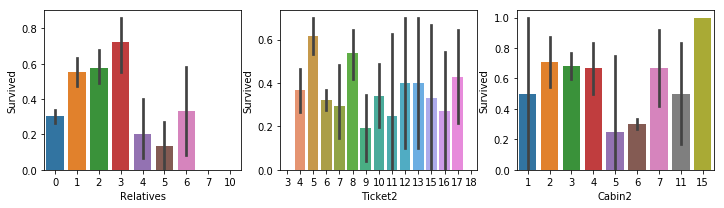

In [20]:
warnings.filterwarnings(action="ignore")
plt.figure(figsize=[12,10])
plt.subplot(3,3,1)
sns.barplot('Relatives','Survived',data=train)
plt.subplot(3,3,2)
sns.barplot('Ticket2','Survived',data=train)
plt.subplot(3,3,3)
sns.barplot('Cabin2','Survived',data=train)


### 1.4 - Prepare for model

In [50]:
#droping features I won't use in model
#train.drop(['PassengerId','Name','Ticket','SibSp','Parch','Ticket','Cabin']
train.drop(['PassengerId','Name','Ticket','SibSp','Parch','Ticket','Cabin'],axis=1,inplace=True)
test.drop(['PassengerId','Name','Ticket','SibSp','Parch','Ticket','Cabin'],axis=1,inplace=True)

In [51]:
titanic=pd.concat([train, test], sort=False)

In [52]:
titanic

,Survived,Pclass,Sex,Age,Fare,Embarked,title,Relatives,Ticket2,Cabin2,Name2
0,0.0,3,male,22.00,7.2500,S,Mr,1,9,6,Braund
1,1.0,1,female,38.00,71.2833,C,Mrs,1,8,3,Cumings
2,1.0,3,female,26.00,7.9250,S,Miss,0,16,6,Heikkinen
3,1.0,1,female,35.00,53.1000,S,Mrs,1,6,4,Futrelle
4,0.0,3,male,35.00,8.0500,S,Mr,0,6,6,Allen
5,0.0,3,male,32.37,8.4583,Q,Mr,0,6,6,Moran
6,0.0,1,male,54.00,51.8625,S,Mr,0,5,3,McCarthy
7,0.0,3,male,2.00,21.0750,S,Master,4,6,6,Palsson
8,1.0,3,female,27.00,11.1333,S,Mrs,2,6,6,Johnson
9,1.0,2,female,14.00,30.0708,C,Mrs,1,6,6,Nasser


In [53]:
titanic=pd.get_dummies(titanic)

In [56]:
titanic.columns

Index(['Survived', 'Pclass', 'Age', 'Fare', 'Relatives', 'Ticket2', 'Cabin2',
       'Sex_female', 'Sex_male', 'Embarked_C',
       ...
       'Name2_Zabour', 'Name2_Zakarian', 'Name2_Zimmerman', 'Name2_de Brito',
       'Name2_de Messemaeker', 'Name2_de Mulder', 'Name2_de Pelsmaeker',
       'Name2_del Carlo', 'Name2_van Billiard', 'Name2_van Melkebeke'],
      dtype='object', length=893)

In [24]:
train=titanic[:len_train]
test=titanic[len_train:]

In [25]:
# Lets change type of target
train.Survived=train.Survived.astype('int')
train.Survived.dtype

dtype('int32')

In [26]:
xtrain=train.drop("Survived",axis=1)
ytrain=train['Survived']
xtest=test.drop("Survived", axis=1)

In [27]:
xtrain

,Pclass,Age,Fare,Relatives,Ticket2,Cabin2,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Name2_Zabour,Name2_Zakarian,Name2_Zimmerman,Name2_de Brito,Name2_de Messemaeker,Name2_de Mulder,Name2_de Pelsmaeker,Name2_del Carlo,Name2_van Billiard,Name2_van Melkebeke
0,3,22.00,7.2500,1,9,6,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,38.00,71.2833,1,8,3,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,26.00,7.9250,0,16,6,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,35.00,53.1000,1,6,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,35.00,8.0500,0,6,6,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3,32.37,8.4583,0,6,6,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
6,1,54.00,51.8625,0,5,3,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,2.00,21.0750,4,6,6,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,3,27.00,11.1333,2,6,6,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2,14.00,30.0708,1,6,6,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# 2 - Nested Cross Validation

### Random Forest

In [26]:
RF=RandomForestClassifier(random_state=1)
PRF=[{'n_estimators':[10,100],'max_depth':[3,6],'criterion':['gini','entropy']}]
GSRF=GridSearchCV(estimator=RF, param_grid=PRF, scoring='accuracy',cv=2)
scores_rf=cross_val_score(GSRF,xtrain,ytrain,scoring='accuracy',cv=5)

In [27]:
np.mean(scores_rf)

0.7866456934513139

### SVM

In [28]:
svc=make_pipeline(StandardScaler(),SVC(random_state=1))
r=[0.0001,0.001,0.1,1,10,50,100]
PSVM=[{'svc__C':r, 'svc__kernel':['linear']},
      {'svc__C':r, 'svc__gamma':r, 'svc__kernel':['rbf']}]
GSSVM=GridSearchCV(estimator=svc, param_grid=PSVM, scoring='accuracy', cv=2)
scores_svm=cross_val_score(GSSVM, xtrain.astype(float), ytrain,scoring='accuracy', cv=5)

In [29]:
np.mean(scores_svm)

0.8439879324218461

# 3 - Submission

In [30]:
model=GSSVM.fit(xtrain, ytrain)

In [31]:
pred=model.predict(xtest)

In [32]:
output=pd.DataFrame({'PassengerId':test2['PassengerId'],'Survived':pred})

In [33]:
output.to_csv('submission.csv', index=False)